<a href="https://colab.research.google.com/github/caiobaptistaa/Econometria-4_PUC-Rio/blob/main/Trabalho_1_Quest_2_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Trabalho 1 - (Questão 2) <h1>

<h2> A) Autoregressive Model <h2>

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import pmdarima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
pd.pandas.set_option('display.max_columns', None)

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pmdarima.arima import auto_arima

def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Trabalho-1/data.csv', sep= ",", low_memory= False)
CPI = pd.read_csv('/content/drive/MyDrive/Trabalho-1/CPI.csv', sep= ",", low_memory= False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
CPI = CPI.reset_index(drop= True)

In [ ]:
CPI_diff = CPI.copy()

In [ ]:
CPI_diff.head()

,sasdate,CPIAUCSL,CPIAUCSL_diff
0,1959-03-01,-0.001036,-0.000691
1,1959-04-01,0.000345,0.001381
2,1959-05-01,0.002066,0.001721
3,1959-06-01,0.002405,0.000339
4,1959-07-01,0.001372,-0.001032


In [ ]:
date = CPI_diff["sasdate"]
date = pd.DataFrame(date)
date = date.reset_index(drop = True)
date

,sasdate
0,1959-03-01
1,1959-04-01
2,1959-05-01
3,1959-06-01
4,1959-07-01
...,...
753,2021-12-01
754,2022-01-01
755,2022-02-01
756,2022-03-01


In [ ]:
CPI_diff = CPI_diff.drop(columns = ["sasdate", "CPIAUCSL"])

In [ ]:
scaler = StandardScaler()
scaler.fit(CPI_diff)
CPI_st = scaler.transform(CPI_diff)

In [ ]:
CPI_st = pd.DataFrame(CPI_st, columns = CPI_diff.columns)
CPI_st.head()

,CPIAUCSL_diff
0,-0.258455
1,0.511228
2,0.637727
3,0.124012
4,-0.385438


In [ ]:
CPI_diff_st = date.merge(CPI_st, left_index = True, right_index = True, how = "left")

In [ ]:
CPI_diff_st.index = pd.DatetimeIndex(CPI_diff_st["sasdate"])
CPI_diff_st = CPI_diff_st.drop(columns = ["sasdate"])

<h3> a) Autoregressive Model <h3>

In [ ]:
 from matplotlib import pyplot as plt

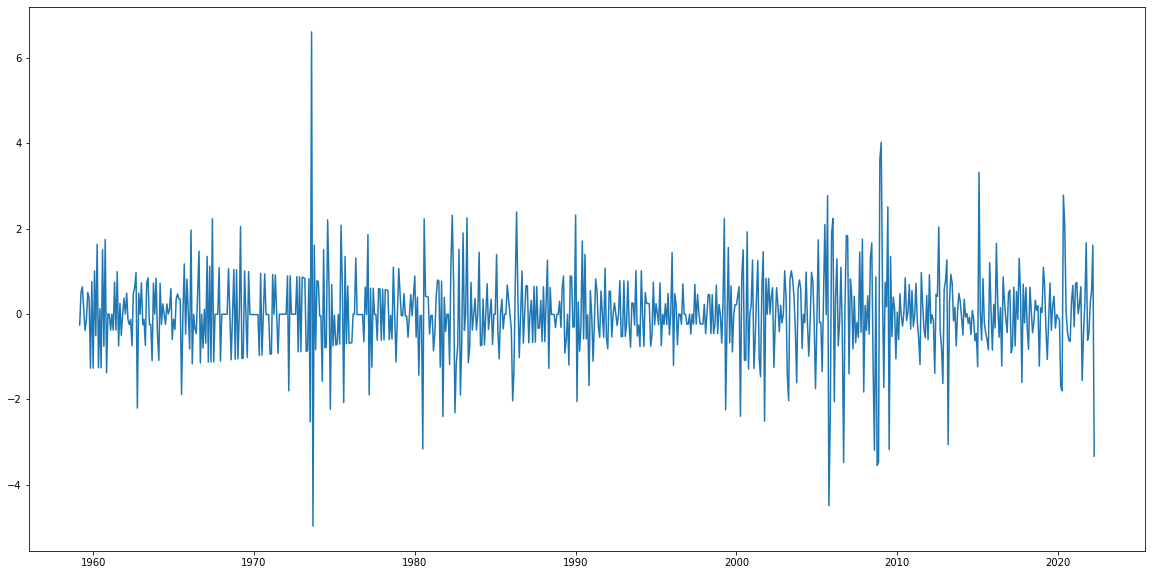

In [ ]:
ts_CPI_diff = pd.Series(CPI_diff_st["CPIAUCSL_diff"].values, index = CPI_diff_st.index)
plt.figure(figsize= (20, 10))
plt.plot(ts_CPI_diff)

Check ACF and PACF

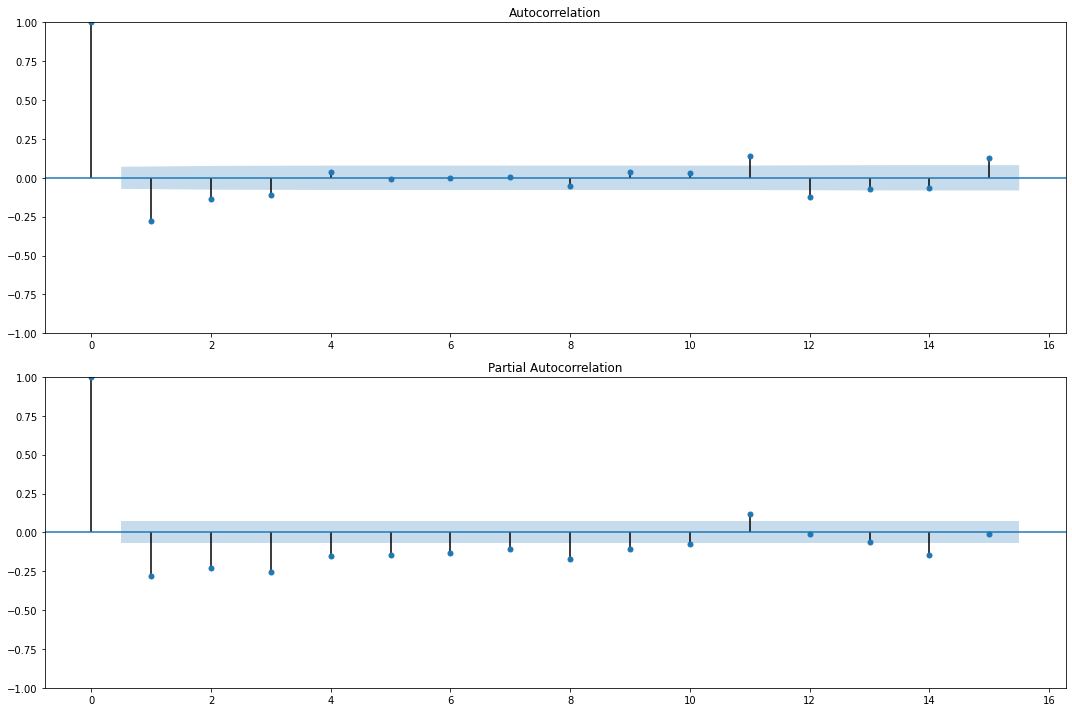

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
plot_acf(ts_CPI_diff,lags=15, ax=ax[0])
plot_pacf(ts_CPI_diff,lags=15, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

Check the information criterions AIC and BIC

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [ ]:
CPI_diff_st.shape

(758, 1)

In [ ]:
CPI_diff_st.head()

,CPIAUCSL_diff
sasdate,
1959-03-01,-0.258455
1959-04-01,0.511228
1959-05-01,0.637727
1959-06-01,0.124012
1959-07-01,-0.385438


Below we can see the Sliding Window Forecast algorithm. The windows are fixed at 492 observations for training and a one-step-ahead prediction 492 + 1. How can we select the best model? Here we select the model by order of AR, and choose the order that generates the smallest BIC. Then, we estimate 12 Autoregressive Models for each estimation window and select the best order, later we estimate the model with this order.
The forecast period is from March 2000 to November 2021.

*   Total Data   : x x x x x x x x x x x x
*   1 estimation : - x x x x x x o - - - - 
*   2 estimation : - - x x x x x x o - - -
*   3 estimation : - - - x x x x x x o - -
*   4 estimation : - - - - x x x x x x o -
*   5 estimation : - - - - - x x x x x x o


Where the x's are the sliding window and the "o" are the predicted observation. (representative number of estimation).

In [ ]:
X = CPI_diff_st["CPIAUCSL_diff"].values
train, test = X[0:492], X[492:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	history = history[-492:]
	model = auto_arima(history, start_p=1, start_q=0,
                      test='adf',
                      max_p=12, max_q=0,
                      m=0, 
                      information_criterion='bic',            
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
	model_fit = model.fit(history)
	output = model_fit.predict(n_periods= 1)
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f, window_size=%f' % (yhat, obs, (len(history)-1)))
mse = mean_squared_error(test, predictions)
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
print('Test MSE: %.5f' % mse, 'Test RMSE: %.5f' % rmse, 'Test MAE: %.5f' % mae)

Estimated results have been deleted for better viewing.

In [ ]:
print('Test MSE: %.5f' % mse, 'Test RMSE: %.5f' % rmse, 'Test MAE: %.5f' % mae)

Test MSE: 1.39196 Test RMSE: 1.17981 Test MAE: 0.82102


In [ ]:
len(predictions), len(test), len(X)

(266, 266, 758)

In [ ]:
predictions = predictions[12:]
len(predictions)

254

In [ ]:
observed = test[12:]
len(observed)

254

In [ ]:
observed = np.array(observed)
predictions = np.array(predictions)
observed = observed.reshape(-1, 1)
predictions = predictions.reshape(-1, 1)
observed.shape, predictions.shape

((254, 1), (254, 1))

In [ ]:
CPI_st.shape

(758, 1)

In [ ]:
observed_copies =  np.repeat(observed, CPI_st.shape[1], axis = -1)
observed_real = scaler.inverse_transform(observed_copies)[:, 0]

In [ ]:
predictions_copies =  np.repeat(predictions, CPI_st.shape[1], axis = -1)
predictions_real = scaler.inverse_transform(predictions_copies)[:, 0]

In [ ]:
date = date[504: len(date)]
date = date.reset_index(drop= True)
date.head()

,sasdate
0,2001-03-01
1,2001-04-01
2,2001-05-01
3,2001-06-01
4,2001-07-01


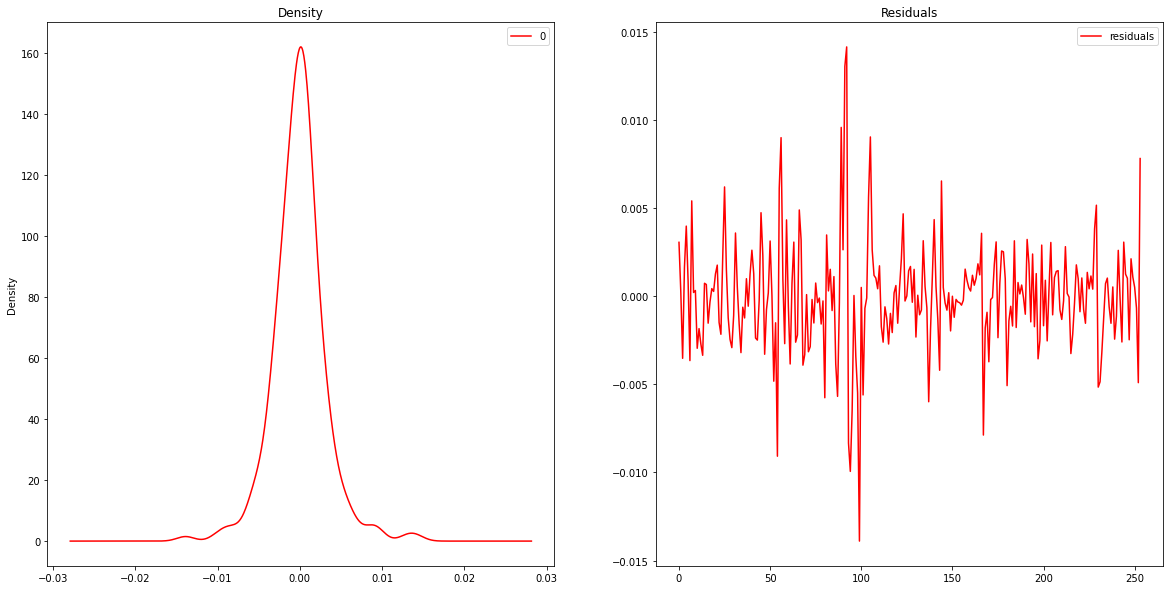

In [ ]:
pred_df = pd.DataFrame(predictions_real)
observed_df = pd.DataFrame(observed_real)
residuals = pd.DataFrame(pred_df - observed_df)
fig, ax = plt.subplots(1,2, figsize = (20, 10))
residuals.plot(kind='kde', title='Density', ax=ax[0], color = "red")
residuals.plot(title="Residuals", ax=ax[1], color = "red")
plt.legend(["residuals"])
plt.show()

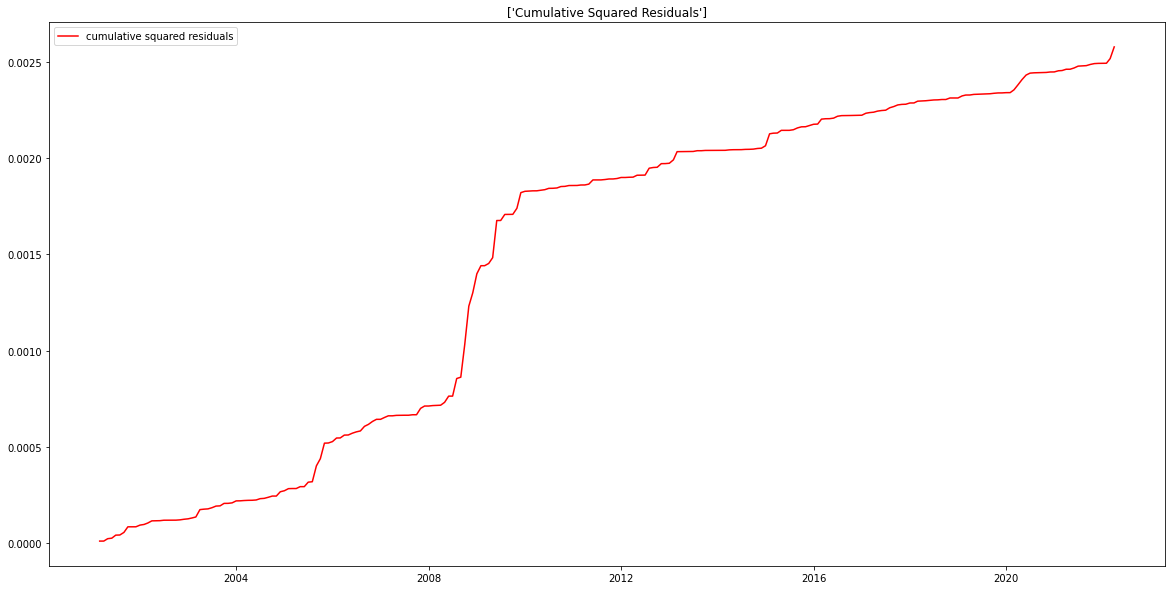

In [ ]:
squared_residuals = residuals**2
cumsum_sqd_residuals = np.cumsum(squared_residuals)
cumsum_sqd_residuals_date = date.merge(cumsum_sqd_residuals, left_index = True, right_index = True, how = "left")
cumsum_sqd_residuals_date.index = pd.DatetimeIndex(cumsum_sqd_residuals_date["sasdate"])
cumsum_sqd_residuals_date = cumsum_sqd_residuals_date.drop(columns = ["sasdate"])

plt.figure(figsize= (20, 10))

plt.plot(cumsum_sqd_residuals_date, color = "red")
plt.title(["Cumulative Squared Residuals"])
plt.legend(["cumulative squared residuals"], loc = "upper left")

In [ ]:
date.head()

,sasdate
0,2001-03-01
1,2001-04-01
2,2001-05-01
3,2001-06-01
4,2001-07-01


In [ ]:
dff = date.merge(pred_df, left_index = True, right_index = True, how = "left")
df = dff.merge(observed_df, left_index = True, right_index = True, how = "left")
df.head()

,sasdate,0_x,0_y
0,2001-03-01,0.001343,-0.001705
1,2001-04-01,0.001358,0.001133
2,2001-05-01,-0.000154,0.003375
3,2001-06-01,-0.001188,-0.002825
4,2001-07-01,0.000026,-0.003942


In [ ]:
df.index = pd.DatetimeIndex(df["sasdate"])
df = df.drop(columns = ["sasdate"])

In [ ]:
df = df.rename(columns = {"0_x" : "pred", "0_y" : "observed"})
df.head()

,pred,observed
sasdate,,
2001-03-01,0.001343,-0.001705
2001-04-01,0.001358,0.001133
2001-05-01,-0.000154,0.003375
2001-06-01,-0.001188,-0.002825
2001-07-01,0.000026,-0.003942


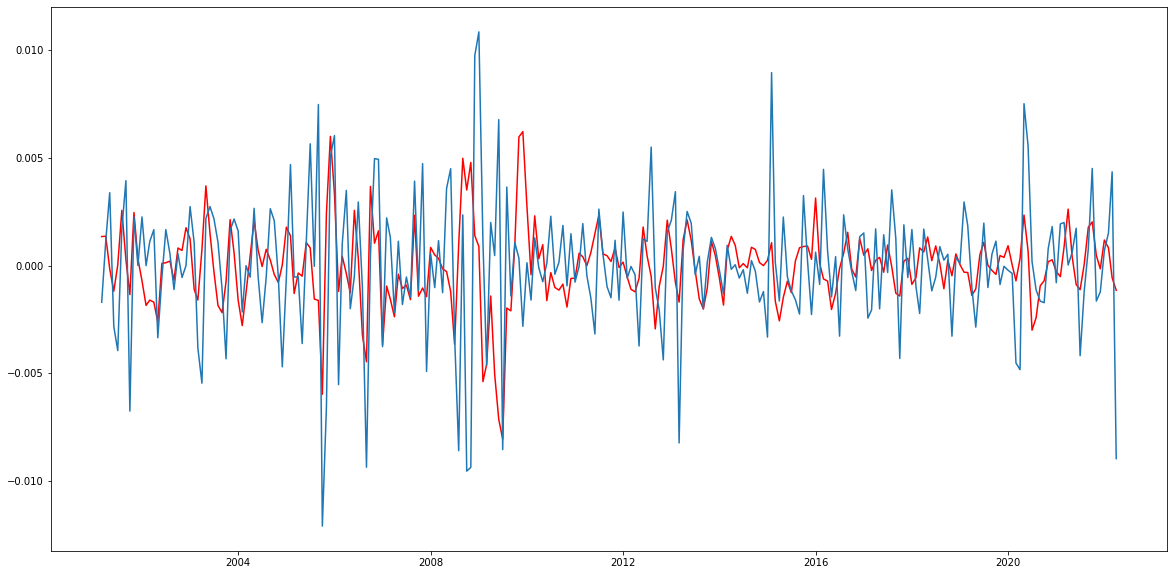

In [ ]:
plt.figure(figsize= (20, 10))
plt.plot(df["pred"], color = "red")
plt.plot(df["observed"])
plt.show()

In [40]:
mse = mean_squared_error(observed_real, predictions_real)
rmse = np.sqrt(mse)
mae = mean_absolute_error(observed_real, predictions_real)
print('MSE: %f' % mse), print('MAE: %f' % mae), print('RMSE: %f' % rmse)

MSE: 0.000010
MAE: 0.002197
RMSE: 0.003186


(None, None, None)

In [ ]:
pred_ar = df["pred"].copy()
pred_ar.head()

sasdate
2001-03-01    0.001343
2001-04-01    0.001358
2001-05-01   -0.000154
2001-06-01   -0.001188
2001-07-01    0.000026
Name: pred, dtype: float64

In [ ]:
pred_ar.shape

(254,)

In [ ]:
pred_ar.to_csv("/content/drive/MyDrive/Trabalho-1/pred_ar.csv", index = False)